In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
import math

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

ROOT_DIR = "dataset/fruit360"
TEST_DIR = os.path.join(ROOT_DIR, "Test")

In [32]:
class Fruit360FolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, variety=False):
        self.root_dir = root_dir
        self.transform = transform
        self.variety = variety
        self.samples = []
        
        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            label = class_name if self.variety else class_name.split()[0]
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.png')):
                    self.samples.append((os.path.join(class_dir, img_name), label))
        
        unique_labels = sorted({lbl for _, lbl in self.samples})
        self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        self.idx_to_label = {i: lbl for i, lbl in self.label_to_idx.items()}
        
        print(f"{os.path.basename(root_dir)}: {len(self.samples)} images, {len(unique_labels)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label_str = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label_str

In [33]:
SIZE_VIS = 100
transform_vis = T.Compose([
    T.Resize((SIZE_VIS, SIZE_VIS)),
    T.ToTensor(),
])

test_dataset = Fruit360FolderDataset(TEST_DIR, transform=transform_vis, variety=False)

classes_to_show = ['Apple', 'Banana', 'Tomato', 'Zucchini', 'Nut', 'Orange', 'Pepper', 'Strawberry']
examples = []
seen_labels = set()
for img, label in test_dataset:
    if label in classes_to_show and label not in seen_labels:
        examples.append((img, label))
        seen_labels.add(label)
    if len(seen_labels) == len(classes_to_show):
        break

print(f"Selected {len(examples)} example images: {[lbl for _, lbl in examples]}")

Test: 43442 images, 79 classes
Selected 8 example images: ['Apple', 'Banana', 'Nut', 'Orange', 'Pepper', 'Strawberry', 'Tomato', 'Zucchini']


In [34]:
def clamp_01(x):
    return torch.clamp(x, 0.0, 1.0)

def add_color_patches(x, num_patches, color, alpha_range=(0.4, 0.7), size_range=(0.05, 0.15)):
    _, H, W = x.shape
    out = x.clone()
    for _ in range(num_patches):
        s = np.random.uniform(size_range[0], size_range[1])
        patch_area = s * H * W / 4
        r = np.random.uniform(0.5, 1.5)
        patch_h = int(math.sqrt(patch_area / r))
        patch_w = int(math.sqrt(patch_area * r))
        patch_h = max(1, min(H, patch_h))
        patch_w = max(1, min(W, patch_w))
        top = np.random.randint(0, H - patch_h + 1)
        left = np.random.randint(0, W - patch_w + 1)
        bottom = top + patch_h
        right = left + patch_w
        alpha = np.random.uniform(alpha_range[0], alpha_range[1])
        patch = out[:, top:bottom, left:right]
        blended = alpha * color + (1 - alpha) * patch
        out[:, top:bottom, left:right] = blended
    return clamp_01(out)

def add_occlusion_patch(x, area_ratio=0.1, color=torch.tensor([0.5, 0.5, 0.5]).view(3,1,1), alpha=0.5):
    _, H, W = x.shape
    out = x.clone()
    patch_area = area_ratio * H * W
    r = np.random.uniform(0.5, 1.5)
    patch_h = int(math.sqrt(patch_area / r))
    patch_w = int(math.sqrt(patch_area * r))
    patch_h = max(1, min(H, patch_h))
    patch_w = max(1, min(W, patch_w))
    top = np.random.randint(0, H - patch_h + 1)
    left = np.random.randint(0, W - patch_w + 1)
    bottom = top + patch_h
    right = left + patch_w
    patch = out[:, top:bottom, left:right]
    blended = alpha * color + (1 - alpha) * patch
    out[:, top:bottom, left:right] = blended
    return clamp_01(out)

color_dirt = torch.tensor([0.3, 0.25, 0.2]).view(3,1,1)
color_bruise = torch.tensor([0.25, 0.2, 0.15]).view(3,1,1)

blur_mild = T.GaussianBlur(kernel_size=3, sigma=0.5)
blur_medium = T.GaussianBlur(kernel_size=5, sigma=1)

def noise_mild(x):
    return clamp_01(x + torch.randn_like(x) * 0.025)

def noise_medium(x):
    return clamp_01(x + torch.randn_like(x) * 0.07)

def dark_mild(x):
    return clamp_01(x * 0.65)

def overexposed_mild(x):
    return clamp_01(x * 1.35)

def dirty_mild(x):
    return add_color_patches(x, num_patches=2, color=color_dirt, alpha_range=(0.5, 0.8), size_range=(0.03, 0.08))

def bruised_mild(x):
    return add_color_patches(x, num_patches=1, color=color_bruise, alpha_range=(0.4, 0.7), size_range=(0.03, 0.08))

def occlusion_small(x):
    return add_occlusion_patch(x, area_ratio=0.10, alpha=0.5)

def scenario_A(x):
    x = blur_medium(x)
    x = noise_mild(x)
    if np.random.rand() < 0.7:
        x = dirty_mild(x)
    return x

def scenario_B(x):
    if np.random.rand() < 0.5:
        x = dark_mild(x)
    else:
        x = overexposed_mild(x)
    x = noise_mild(x)
    return x

def scenario_C(x):
    x = occlusion_small(x)
    if np.random.rand() < 0.5:
        x = bruised_mild(x)
    else:
        x = dirty_mild(x)
    return x



Realistic scenarios defined:
  - clean
  - scenario_A
  - scenario_B
  - scenario_C


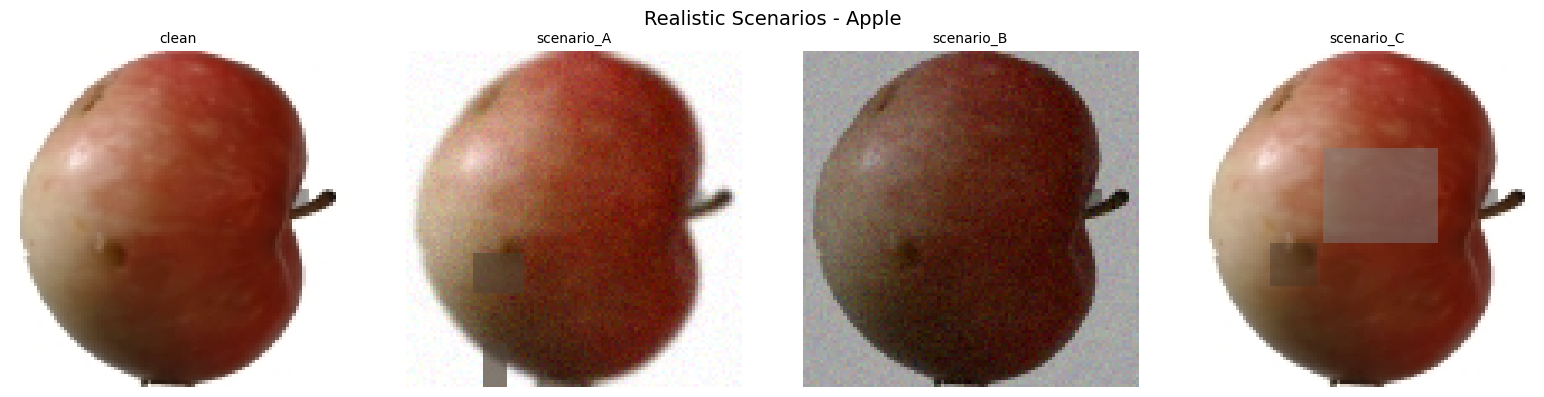

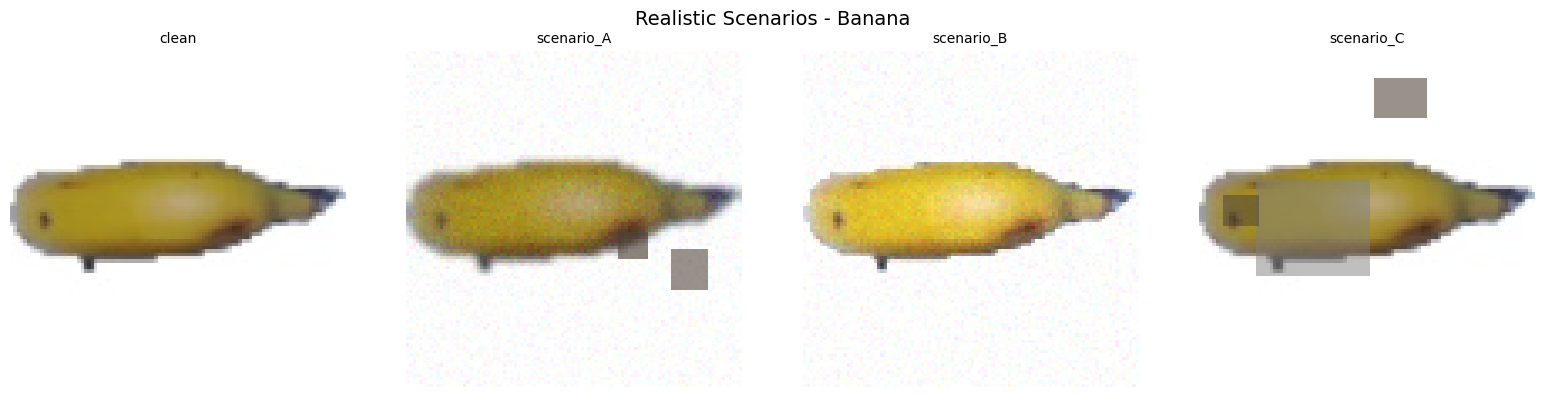

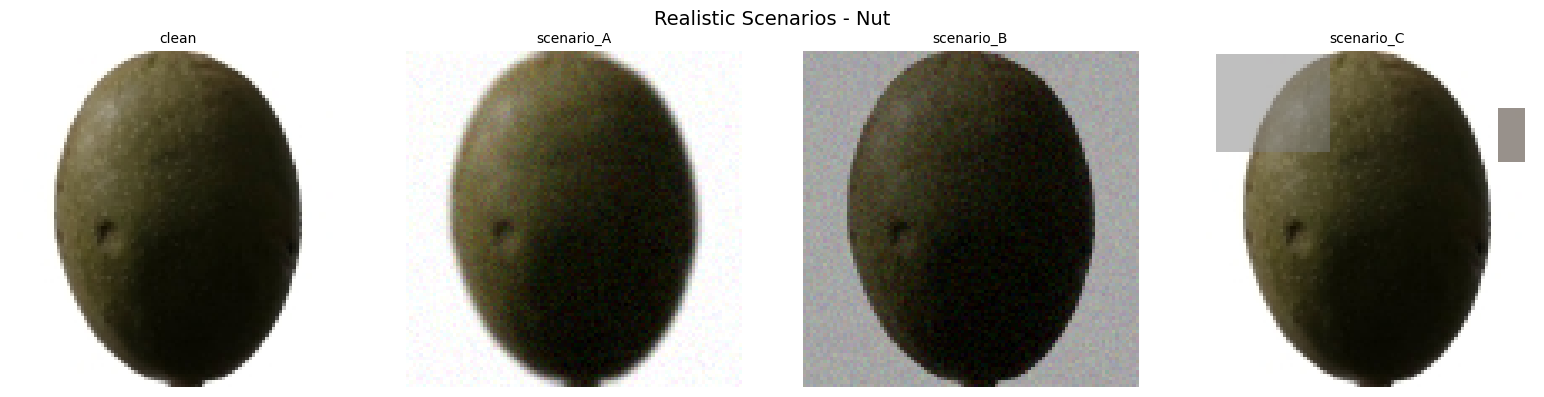

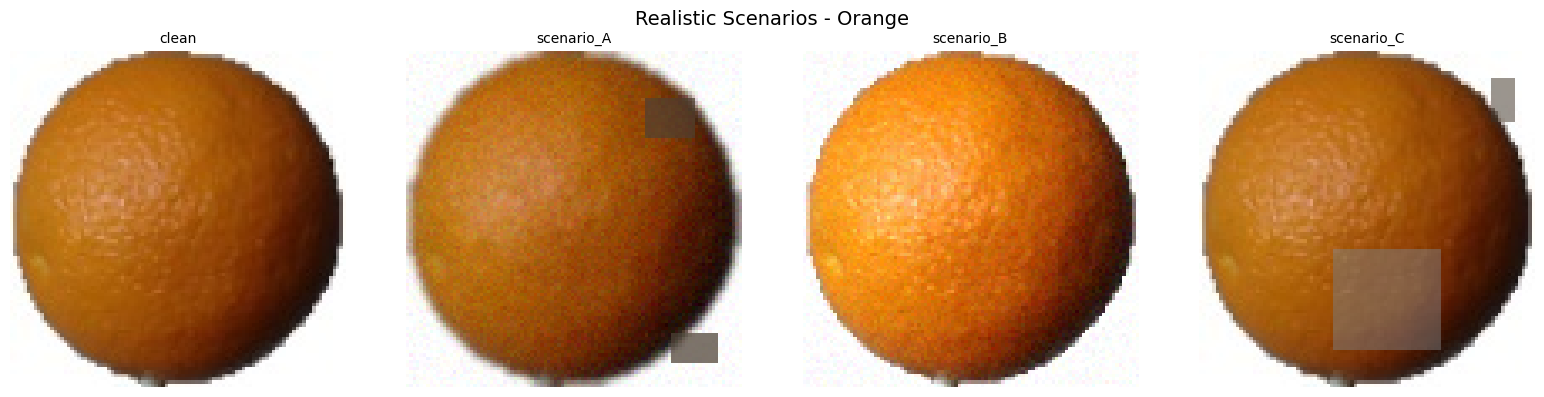

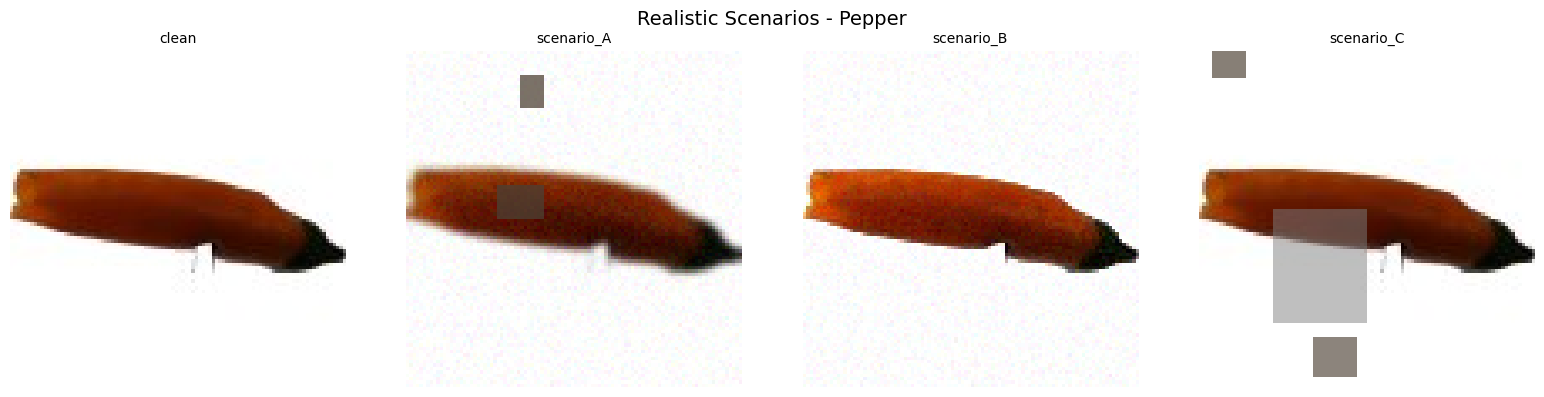

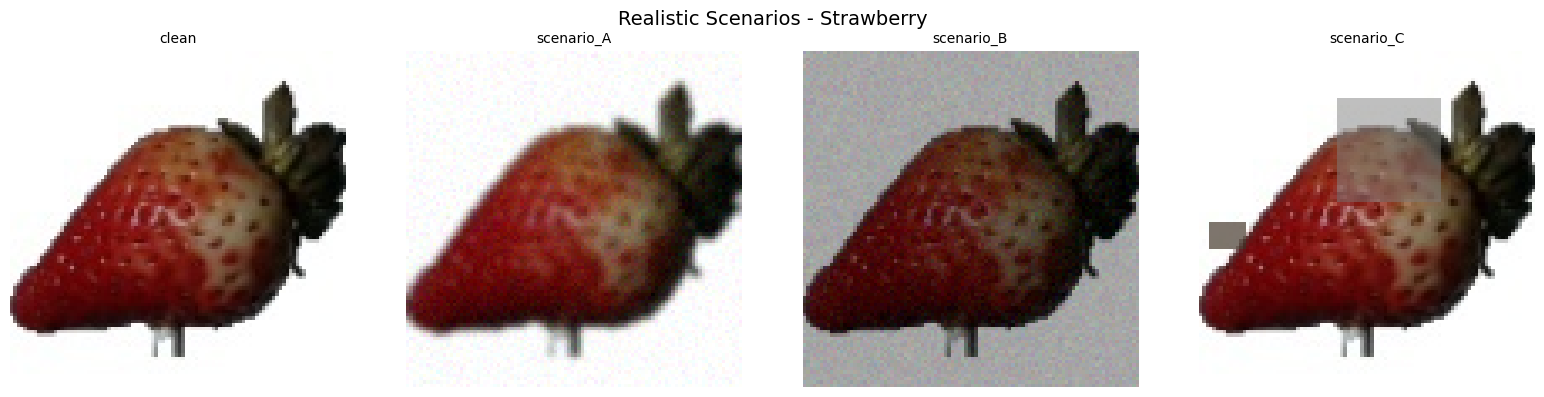

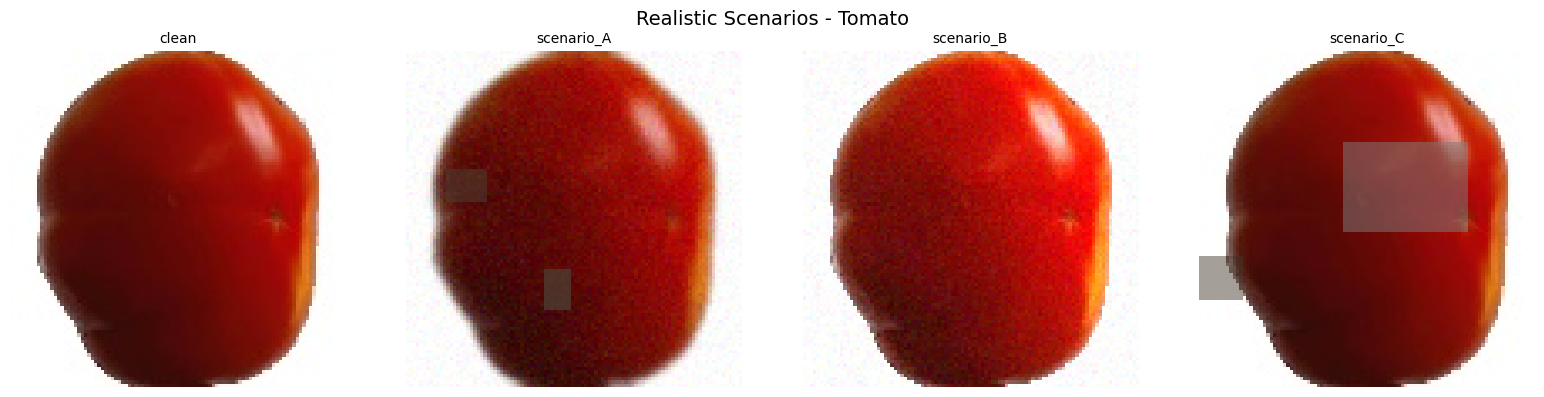

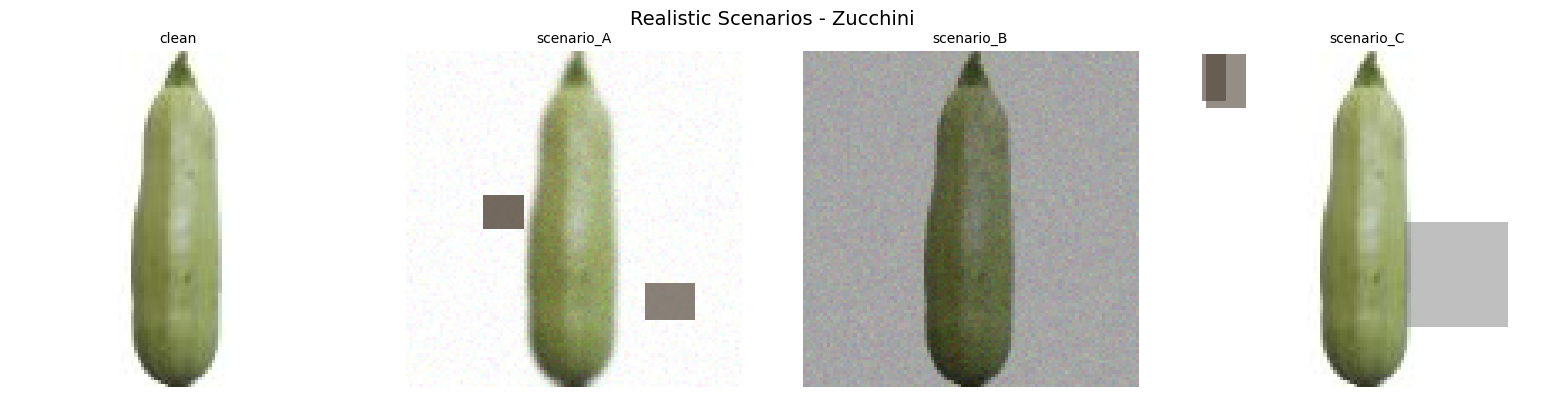

In [35]:
scenarios = {
    'clean': lambda x: x,
    'scenario_A': scenario_A,
    'scenario_B': scenario_B,
    'scenario_C': scenario_C,
}

print("\nRealistic scenarios defined:")
for k in scenarios.keys():
    print(f"  - {k}")

def show_scenarios_for_image(img_tensor, label, scenarios_dict, title_prefix="", ncols=4, figsize=(16, 4)):
    names = list(scenarios_dict.keys())
    n = len(names)
    nrows = int(np.ceil(n / ncols))
    
    plt.figure(figsize=figsize)
    for i, name in enumerate(names):
        ax = plt.subplot(nrows, ncols, i+1)
        with torch.no_grad():
            x_deg = scenarios_dict[name](img_tensor)
            x_deg = clamp_01(x_deg)
            img_np = x_deg.permute(1, 2, 0).cpu().numpy()
        ax.imshow(img_np)
        ax.set_title(name, fontsize=10)
        ax.axis('off')
    
    plt.suptitle(f"{title_prefix}{label}", fontsize=14)
    plt.tight_layout()
    plt.show()

num_examples = min(8, len(examples))
for i in range(num_examples):
    img, label = examples[i]
    show_scenarios_for_image(
        img_tensor=img,
        label=label,
        scenarios_dict=scenarios,
        title_prefix="Realistic Scenarios - ",
        ncols=4,
        figsize=(16, 4)
    )
